In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import medmnist
from medmnist import DermaMNIST
from medmnist import INFO, Evaluator
import warnings
warnings.filterwarnings('ignore')

# For integrated gradients
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz

# For calibration
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
data_flag = 'dermamnist'
download = False

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Load datasets
val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode == 'L' else x),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_dataset = DermaMNIST(split='test', transform=val_transform, download=False)
val_dataset = DermaMNIST(split='val', transform=val_transform, download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Load trained model
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(1280, n_classes)
model.load_state_dict(torch.load('best_efficientnet_b0.pth'))
model = model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Number of classes: {n_classes}")

Model loaded successfully!
Number of classes: 7


Computing predictions and confidence scores...


100%|██████████| 32/32 [02:02<00:00,  3.81s/it]


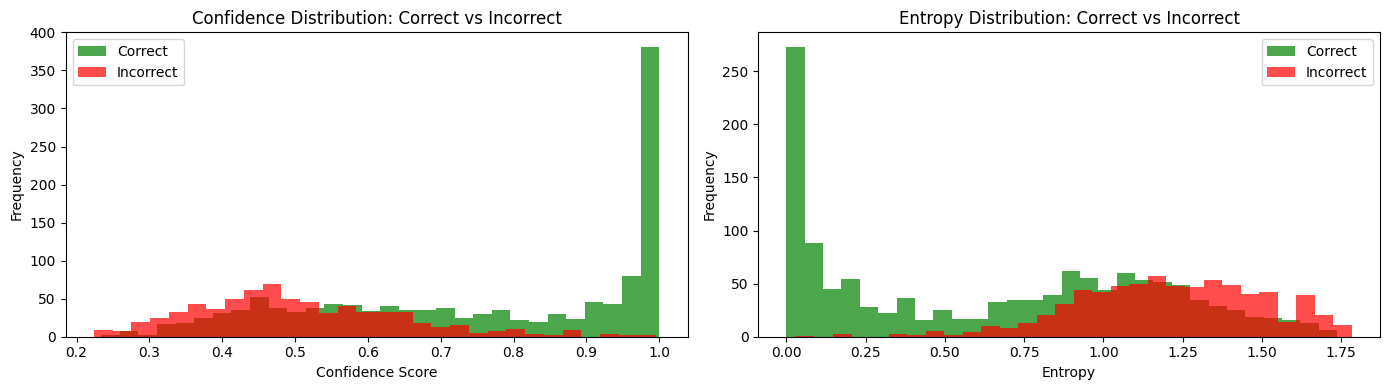


Confidence Statistics:
Mean confidence (correct): 0.7570
Mean confidence (incorrect): 0.5050
Mean entropy (correct): 0.6452
Mean entropy (incorrect): 1.2041


In [3]:
def get_predictions_and_confidence(model, dataloader, device):
    """Get predictions, confidence, and uncertainty estimates"""
    all_preds = []
    all_confidence = []
    all_entropy = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            confidence, preds = torch.max(probs, 1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_confidence.append(confidence.cpu().numpy())
            all_entropy.append(entropy.cpu().numpy())
            all_targets.append(targets.squeeze().numpy())
    
    return {
        'preds': np.concatenate(all_preds),
        'confidence': np.concatenate(all_confidence),
        'entropy': np.concatenate(all_entropy),
        'targets': np.concatenate(all_targets)
    }

print("Computing predictions and confidence scores...")
test_results = get_predictions_and_confidence(model, test_loader, device)
val_results = get_predictions_and_confidence(model, val_loader, device)

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Correct vs Incorrect predictions
correct = test_results['preds'] == test_results['targets']
axes[0].hist(test_results['confidence'][correct], bins=30, alpha=0.7, label='Correct', color='green')
axes[0].hist(test_results['confidence'][~correct], bins=30, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Confidence Distribution: Correct vs Incorrect')
axes[0].legend()

# Entropy distribution
axes[1].hist(test_results['entropy'][correct], bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(test_results['entropy'][~correct], bins=30, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Entropy')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Entropy Distribution: Correct vs Incorrect')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"Mean confidence (correct): {test_results['confidence'][correct].mean():.4f}")
print(f"Mean confidence (incorrect): {test_results['confidence'][~correct].mean():.4f}")
print(f"Mean entropy (correct): {test_results['entropy'][correct].mean():.4f}")
print(f"Mean entropy (incorrect): {test_results['entropy'][~correct].mean():.4f}")


Calibration Metrics:
Expected Calibration Error (ECE): 0.0328
Maximum Calibration Error (MCE): 0.0842
Brier Score: 0.1679
Accuracy: 0.6479


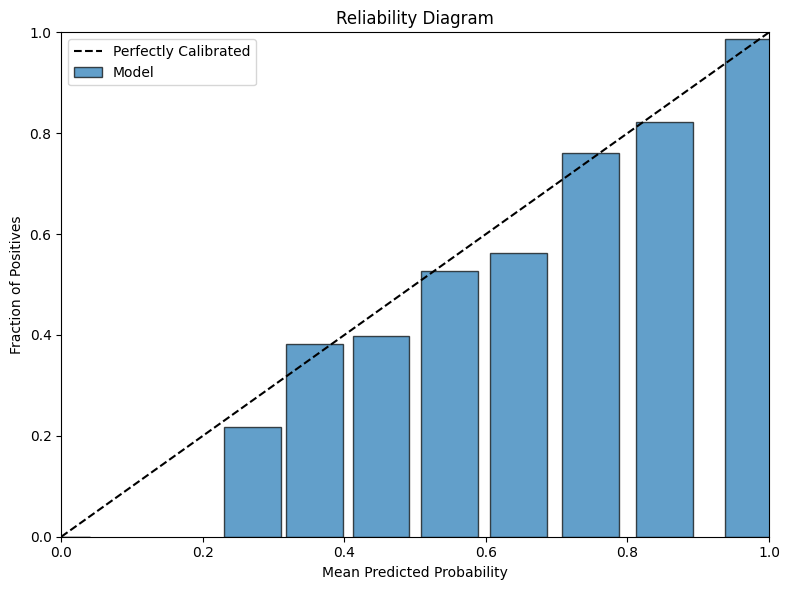

In [ ]:
def compute_calibration_metrics(predictions, confidence, targets, n_classes):
    """Compute ECE, MCE, and Brier score"""
    accuracy = (predictions == targets).astype(float)
    
    # Expected Calibration Error (ECE)
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowerbound = bin_boundaries[:-1]
    bin_upperbound = bin_boundaries[1:]
    
    ece = 0
    mce = 0
    
    for i in range(n_bins):
        mask = (confidence > bin_lowerbound[i]) & (confidence <= bin_upperbound[i])
        if mask.sum() > 0:
            bin_accuracy = accuracy[mask].mean()
            bin_confidence = confidence[mask].mean()
            bin_count = mask.sum()
            ece += np.abs(bin_accuracy - bin_confidence) * (bin_count / len(predictions))
            mce = max(mce, np.abs(bin_accuracy - bin_confidence))
    
    # Brier Score (for multiclass - average over all classes)
    # Convert to one-hot encoding
    y_true_onehot = np.zeros((len(targets), n_classes))
    y_true_onehot[np.arange(len(targets)), targets] = 1
    
    brier = np.mean((confidence - accuracy) ** 2)
    
    return {
        'ece': ece,
        'mce': mce,
        'brier': brier,
        'accuracy': accuracy.mean()
    }

cal_metrics = compute_calibration_metrics(test_results['preds'], test_results['confidence'], test_results['targets'], n_classes)

print("\nCalibration Metrics:")
print(f"Expected Calibration Error (ECE): {cal_metrics['ece']:.4f}")
print(f"Maximum Calibration Error (MCE): {cal_metrics['mce']:.4f}")
print(f"Brier Score: {cal_metrics['brier']:.4f}")
print(f"Accuracy: {cal_metrics['accuracy']:.4f}")

# Reliability diagram
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_sums = np.zeros(n_bins)
bin_true = np.zeros(n_bins)
bin_total = np.zeros(n_bins)

for i in range(n_bins):
    mask = (test_results['confidence'] > bin_boundaries[i]) & (test_results['confidence'] <= bin_boundaries[i+1])
    bin_sums[i] = test_results['confidence'][mask].sum()
    bin_true[i] = (test_results['preds'][mask] == test_results['targets'][mask]).sum()
    bin_total[i] = mask.sum()

bin_accuracy = np.divide(bin_true, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))
bin_avg_confidence = np.divide(bin_sums, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))

ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax.bar(bin_avg_confidence, bin_accuracy, width=0.08, alpha=0.7, edgecolor='black', label='Model')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Reliability Diagram')
ax.legend()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [ ]:
class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature(model, val_loader, device):
    """Learn optimal temperature for calibration"""
    temperature_model = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=50)
    
    def eval_temp():
        loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.squeeze().long().to(device)
                
                logits = model(inputs)
                scaled_logits = temperature_model(logits)
                loss += criterion(scaled_logits, targets).item()
        
        return loss / len(val_loader)
    
    def closure():
        optimizer.zero_grad()
        loss = 0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)
            
            logits = model(inputs)
            scaled_logits = temperature_model(logits)
            loss += criterion(scaled_logits, targets)
        
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    optimal_temp = temperature_model.temperature.item()
    print(f"\nOptimal Temperature: {optimal_temp:.4f}")
    
    return optimal_temp

# Learn optimal temperature from validation set
print("Learning optimal temperature for calibration...")
optimal_temperature = calibrate_temperature(model, val_loader, device)

# Evaluate calibration with temperature scaling
def get_predictions_with_temperature(model, dataloader, device, temperature):
    """Get predictions with temperature scaling applied"""
    all_preds = []
    all_confidence = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing scaled predictions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Apply temperature scaling
            scaled_outputs = outputs / temperature
            probs = F.softmax(scaled_outputs, dim=1)
            
            confidence, preds = torch.max(probs, 1)
            
            all_preds.append(preds.cpu().numpy())
            all_confidence.append(confidence.cpu().numpy())
            all_targets.append(targets.squeeze().numpy())
    
    return {
        'preds': np.concatenate(all_preds),
        'confidence': np.concatenate(all_confidence),
        'targets': np.concatenate(all_targets)
    }

test_results_scaled = get_predictions_with_temperature(model, test_loader, device, optimal_temperature)

cal_metrics_scaled = compute_calibration_metrics(test_results_scaled['preds'], test_results_scaled['confidence'], test_results_scaled['targets'], n_classes)

print("\nCalibration Metrics (After Temperature Scaling):")
print(f"Expected Calibration Error (ECE): {cal_metrics_scaled['ece']:.4f}")
print(f"Maximum Calibration Error (MCE): {cal_metrics_scaled['mce']:.4f}")
print(f"Brier Score: {cal_metrics_scaled['brier']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Before temperature scaling
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_sums = np.zeros(n_bins)
bin_true = np.zeros(n_bins)
bin_total = np.zeros(n_bins)

for i in range(n_bins):
    mask = (test_results['confidence'] > bin_boundaries[i]) & (test_results['confidence'] <= bin_boundaries[i+1])
    bin_sums[i] = test_results['confidence'][mask].sum()
    bin_true[i] = (test_results['preds'][mask] == test_results['targets'][mask]).sum()
    bin_total[i] = mask.sum()

bin_accuracy = np.divide(bin_true, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))
bin_avg_confidence = np.divide(bin_sums, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].bar(bin_avg_confidence, bin_accuracy, width=0.08, alpha=0.7, edgecolor='black', label='Model')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title(f'Before Temperature Scaling\nECE: {cal_metrics["ece"]:.4f}')
axes[0].legend()
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Plot 2: After temperature scaling
bin_sums_scaled = np.zeros(n_bins)
bin_true_scaled = np.zeros(n_bins)
bin_total_scaled = np.zeros(n_bins)

for i in range(n_bins):
    mask = (test_results_scaled['confidence'] > bin_boundaries[i]) & (test_results_scaled['confidence'] <= bin_boundaries[i+1])
    bin_sums_scaled[i] = test_results_scaled['confidence'][mask].sum()
    bin_true_scaled[i] = (test_results_scaled['preds'][mask] == test_results_scaled['targets'][mask]).sum()
    bin_total_scaled[i] = mask.sum()

bin_accuracy_scaled = np.divide(bin_true_scaled, bin_total_scaled, where=bin_total_scaled>0, out=np.zeros_like(bin_total_scaled))
bin_avg_confidence_scaled = np.divide(bin_sums_scaled, bin_total_scaled, where=bin_total_scaled>0, out=np.zeros_like(bin_total_scaled))

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1].bar(bin_avg_confidence_scaled, bin_accuracy_scaled, width=0.08, alpha=0.7, edgecolor='black', label='Model', color='green')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title(f'After Temperature Scaling (T={optimal_temperature:.2f})\nECE: {cal_metrics_scaled["ece"]:.4f}')
axes[1].legend()
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nImprovement: ECE reduced from {cal_metrics['ece']:.4f} to {cal_metrics_scaled['ece']:.4f}")

Learning optimal temperature for calibration...


In [ ]:
def get_sample_from_loader(loader, idx=0):
    """Get a specific sample from dataloader"""
    for i, (inputs, targets) in enumerate(loader):
        if i == idx:
            return inputs, targets
    return None, None

def visualize_attribution(model, inputs, targets, method='integrated_gradients', device='cpu'):
    """Generate and visualize attribution maps"""
    inputs = inputs.to(device)
    inputs.requires_grad = True
    
    if method == 'integrated_gradients':
        ig = IntegratedGradients(model)
        attr = ig.attribute(inputs, target=targets.to(device))
    elif method == 'saliency':
        saliency = Saliency(model)
        attr = saliency.attribute(inputs, target=targets.to(device))
    
    return attr.cpu().detach().numpy()

# Visualize correct predictions
print("\nGenerating attribution maps for correct predictions...")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Integrated Gradients - Correct Predictions', fontsize=16)

correct_indices = np.where(test_results['preds'] == test_results['targets'])[0][:12]

for idx, sample_idx in enumerate(correct_indices):
    # Get sample
    inputs, targets = None, None
    for i, (inps, tgts) in enumerate(test_loader):
        if i * 32 + sample_idx % 32 < sample_idx:
            continue
        inputs = inps[sample_idx % 32:sample_idx % 32 + 1]
        targets = tgts[sample_idx % 32:sample_idx % 32 + 1]
        break
    
    if inputs is None:
        continue
    
    # Get attribution
    attr = visualize_attribution(model, inputs, targets[0], method='integrated_gradients', device=device)
    
    # Denormalize image
    image = inputs[0].permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    # Plot
    ax = axes[idx // 4, idx % 4]
    ax.imshow(image, cmap='gray')
    ax.imshow(attr[0].mean(axis=0), cmap='hot', alpha=0.4)
    ax.set_title(f'Pred: {test_results["preds"][sample_idx]}, True: {test_results["targets"][sample_idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize incorrect predictions
print("\nGenerating attribution maps for incorrect predictions...")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Integrated Gradients - Incorrect Predictions', fontsize=16)

incorrect_indices = np.where(test_results['preds'] != test_results['targets'])[0][:12]

for idx, sample_idx in enumerate(incorrect_indices):
    # Get sample (simplified approach)
    sample_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    inputs, targets = None, None
    
    for i, (inps, tgts) in enumerate(sample_loader):
        if i == sample_idx:
            inputs = inps
            targets = tgts
            break
    
    if inputs is None:
        continue
    
    # Get attribution
    attr = visualize_attribution(model, inputs, targets[0], method='integrated_gradients', device=device)
    
    # Denormalize image
    image = inputs[0].permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    # Plot
    ax = axes[idx // 4, idx % 4]
    ax.imshow(image, cmap='gray')
    ax.imshow(attr[0].mean(axis=0), cmap='hot', alpha=0.4)
    
    pred = model(inputs.to(device)).argmax(dim=1).item()
    true = targets[0].item()
    ax.set_title(f'Pred: {pred}, True: {true}', color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class MCDropoutModel(nn.Module):
    """Wrapper for MC Dropout inference"""
    def __init__(self, model):
        super(MCDropoutModel, self).__init__()
        self.model = model
        self.enable_dropout()
    
    def enable_dropout(self):
        """Enable dropout during inference"""
        for module in self.model.modules():
            if isinstance(module, nn.Dropout):
                module.train()
    
    def forward(self, x, n_iterations=10):
        """Run inference multiple times with dropout enabled"""
        predictions = []
        
        with torch.no_grad():
            for _ in range(n_iterations):
                pred = self.model(x)
                predictions.append(pred)
        
        predictions = torch.stack(predictions)  # (n_iterations, batch, classes)
        return predictions

def mc_dropout_uncertainty(model, dataloader, device, n_iterations=10):
    """Compute uncertainty estimates using MC Dropout"""
    mc_model = MCDropoutModel(model)
    mc_model = mc_model.to(device)
    
    all_means = []
    all_stds = []
    all_entropy = []
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            
            # Run MC dropout
            predictions = mc_model(inputs, n_iterations=n_iterations)  # (n_iter, batch, classes)
            
            # Compute statistics
            probs = F.softmax(predictions, dim=2)  # (n_iter, batch, classes)
            
            # Mean and std of probabilities
            mean_probs = probs.mean(dim=0)  # (batch, classes)
            std_probs = probs.std(dim=0)    # (batch, classes)
            
            # Predictive entropy (uncertainty)
            entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
            
            # Variation ratio (disagreement)
            pred_classes = predictions.argmax(dim=2)  # (n_iter, batch)
            mode_pred = torch.mode(pred_classes, dim=0)[0]  # (batch,)
            
            all_means.append(mean_probs.cpu().numpy())
            all_stds.append(std_probs.cpu().numpy())
            all_entropy.append(entropy.cpu().numpy())
            all_targets.append(targets.squeeze().numpy())
            all_preds.append(mode_pred.cpu().numpy())
    
    return {
        'mean': np.vstack(all_means),
        'std': np.vstack(all_stds),
        'entropy': np.concatenate(all_entropy),
        'preds': np.concatenate(all_preds),
        'targets': np.concatenate(all_targets)
    }

print("\nComputing MC Dropout uncertainties...")
mc_results = mc_dropout_uncertainty(model, test_loader, device, n_iterations=20)

# Visualize uncertainty
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

correct_mc = mc_results['preds'] == mc_results['targets']

# Plot 1: Entropy
axes[0].hist(mc_results['entropy'][correct_mc], bins=30, alpha=0.7, label='Correct', color='green')
axes[0].hist(mc_results['entropy'][~correct_mc], bins=30, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Predictive Entropy')
axes[0].set_ylabel('Frequency')
axes[0].set_title('MC Dropout: Predictive Entropy')
axes[0].legend()

# Plot 2: Mean std
mean_std = mc_results['std'].mean(axis=1)
axes[1].hist(mean_std[correct_mc], bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(mean_std[~correct_mc], bins=30, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Mean Std Dev')
axes[1].set_ylabel('Frequency')
axes[1].set_title('MC Dropout: Mean Uncertainty')
axes[1].legend()

# Plot 3: Reliability diagram for MC dropout
bin_boundaries = np.linspace(0, 1, 11)
bin_sums = np.zeros(10)
bin_true = np.zeros(10)
bin_total = np.zeros(10)

max_confidence = mc_results['mean'].max(axis=1)

for i in range(10):
    mask = (max_confidence > bin_boundaries[i]) & (max_confidence <= bin_boundaries[i+1])
    bin_sums[i] = max_confidence[mask].sum()
    bin_true[i] = (mc_results['preds'][mask] == mc_results['targets'][mask]).sum()
    bin_total[i] = mask.sum()

bin_accuracy = np.divide(bin_true, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))
bin_avg_confidence = np.divide(bin_sums, bin_total, where=bin_total>0, out=np.zeros_like(bin_total))

axes[2].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[2].bar(bin_avg_confidence, bin_accuracy, width=0.08, alpha=0.7, edgecolor='black', label='MC Dropout')
axes[2].set_xlabel('Mean Predicted Probability')
axes[2].set_ylabel('Fraction of Positives')
axes[2].set_title('MC Dropout: Reliability Diagram')
axes[2].legend()
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nMC Dropout Statistics:")
print(f"Mean entropy (correct): {mc_results['entropy'][correct_mc].mean():.4f}")
print(f"Mean entropy (incorrect): {mc_results['entropy'][~correct_mc].mean():.4f}")
print(f"MC Dropout Accuracy: {(mc_results['preds'] == mc_results['targets']).mean():.4f}")

In [ ]:
def analyze_failures(model, dataloader, device, n_samples=20):
    """Analyze incorrect predictions in detail"""
    sample_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    failures = []
    confidences = []
    
    for i, (inputs, targets) in enumerate(sample_loader):
        if len(failures) >= n_samples:
            break
        
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)
        
        if pred.item() != targets.item():
            failures.append({
                'image': inputs,
                'pred': pred.item(),
                'target': targets.item(),
                'confidence': confidence.item(),
                'all_probs': probs[0].cpu().detach().numpy()
            })
    
    return failures

print("\nAnalyzing failure cases...")
failures = analyze_failures(model, test_loader, device, n_samples=20)

# Visualize failure cases
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
fig.suptitle('Model Failure Cases with Confidence Scores', fontsize=16)

for idx, failure in enumerate(failures[:20]):
    row = idx // 5
    col = idx % 5
    
    image = failure['image'][0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Pred: {failure["pred"]}\nTrue: {failure["target"]}\nConf: {failure["confidence"]:.3f}', 
                             color='red', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Print top confused class pairs
print("\nTop Confused Class Pairs:")
confusion_counts = {}
for failure in failures:
    pair = (failure['target'], failure['pred'])
    confusion_counts[pair] = confusion_counts.get(pair, 0) + 1

for pair, count in sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"True class {pair[0]} predicted as {pair[1]}: {count} times")

In [ ]:
print("\n" + "="*70)
print("MODEL INTERPRETABILITY AND UNCERTAINTY ANALYSIS REPORT")
print("="*70)

print("\n1. CALIBRATION SUMMARY:")
print(f"   - ECE (Original): {cal_metrics['ece']:.4f}")
print(f"   - MCE (Original): {cal_metrics['mce']:.4f}")
print(f"   - ECE (After Temp Scaling): {cal_metrics_scaled['ece']:.4f}")
print(f"   - Optimal Temperature: {optimal_temperature:.4f}")

print("\n2. CONFIDENCE ANALYSIS:")
print(f"   - Mean confidence (correct predictions): {test_results['confidence'][test_results['preds'] == test_results['targets']].mean():.4f}")
print(f"   - Mean confidence (incorrect predictions): {test_results['confidence'][test_results['preds'] != test_results['targets']].mean():.4f}")

print("\n3. MONTE CARLO DROPOUT UNCERTAINTY:")
print(f"   - Mean entropy (correct): {mc_results['entropy'][mc_results['preds'] == mc_results['targets']].mean():.4f}")
print(f"   - Mean entropy (incorrect): {mc_results['entropy'][mc_results['preds'] != mc_results['targets']].mean():.4f}")

print("\n4. FAILURE ANALYSIS:")
print(f"   - Total failures analyzed: {len(failures)}")
print(f"   - Top confused class pair: {sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)[0]}")

print("\n5. RECOMMENDATIONS:")
print("   - Use Temperature Scaling for better calibration")
print("   - Apply MC Dropout for uncertainty quantification")
print("   - Review high-confidence incorrect predictions")
print("   - Focus on improving confused class pairs")

print("\n" + "="*70)